<a href="https://colab.research.google.com/github/Sobiii/Search-Engine-Design-G4/blob/main/IRAssignment_3_FinalEdition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Extraction

The section below extracts the 3 files from the CISI data collection:
- CISI.ALL: containing information about the documents.
- CISI.QRY: containing a list of queries to be executed against our retrieval system.
- CISI.REL: contains appropriate relevance assessments to be used in the evaluation of our models.



##### **Loading the files**

In [828]:
import os as os
import re

# obtains the current working directory of the notebook
directory = os.getcwd()

# defines paths to CISI dataset files
cisi_all_path = os.path.join(directory, 'CISI.ALL')
cisi_qry_path = os.path.join(directory, 'CISI.QRY')
cisi_rel_path = os.path.join(directory, 'CISI.REL')

##### **CISI.ALL Extraction**

The CISI.ALL file contains a collection of text documents, where each document represents a bibliographic record and contains various tags that provide metadata about the document. 

These tags are:

1) [.I] Document ID: A unique identifier assigned to each document in the collection.<br>
2) [.T ]Title: The title of the document, which provides a brief description of the content.<br>
3) [.A] Author: The name(s) of the author(s) of the document.<br>
4) [.B] Source: The source of the document.<br>
4) [.W] Abstract: A summary or brief description of the content of the document.<br>
5) [.y] Publication Date: The date of publication of the document.<br>
6) [.X ]Keywords: Terms or phrases that represent the main topics or subjects covered in the document.<br>

However not all tags and metadata are included for each document.

In [829]:
# function extracting text in the CISI.ALL file line by line and populating id, title, author, abstract and publication information fields
def all_extraction(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    doc_ids = []
    documents = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"): # if a line starts with '.I', the following line will be the document ID
            doc_id = file_lines[i].split()[1]
            doc_ids.append(doc_id)
            if file_lines[i+1].startswith(".T") and file_lines[i+3].startswith(".A"): # selecting text between the .T and .A tags
                title = file_lines[i+2][:].strip() # saved into the title tag
            else:
                title = file_lines[i+2].strip() + " " + file_lines[i+3].strip()
            authors = ""
            if any([line.startswith(".A") for line in file_lines[i+1:]]): # selecting text after the .A tag
                author_start = i+4 # saved as author 
                author_end = author_start
                while author_end < len(file_lines) and not any([file_lines[author_end].startswith(tag) for tag in [".T", ".B", ".W", ".Y"]]):
                    author_end += 1 # checks for documents with multiple authors 
                authors = " ".join([file_lines[j].strip() for j in range(author_start, author_end)]).strip()
                authors = re.sub(r"^\s*\.\s*A\s*", "", authors)
                abstract_start = author_end # selects text after the author lines as the start of the abstract
            else:
                abstract_start = i+4

            for t in range(i+4, len(file_lines)):
                if file_lines[t].startswith(".X"): # abstract text ends before the .X keywords tag
                    abstract_end = t
                    break
            else:
                abstract_end = len(file_lines)
            abstract = " ".join(file_lines[abstract_start:abstract_end]).strip().replace('\n', ' ')
            abstract = re.sub(r"^\s*\.\s*W\s*", "", abstract)
            abstract = " ".join(abstract.split())
            source = re.search(r"\.B\s+(.*)\.W", abstract)
            if source: # saves source information (.B) if present
                source = source.group(1)
                source = re.sub(r"^\s*\.\s*A\s*", "", source)
                source = re.sub(r"^\s*\.\s*B\s*", "", source)
            else:
                source = ""
            abstract = re.sub(r"^\s*\.\s*B\s*(.*)\.W", "", abstract)
            abstract = " ".join(abstract.split())
            year = re.search(r"\.Y\s+(\d{4})", abstract)
            if year: # saves publication date (.Y) if present
                year = int(year.group(1))
            else:
                year = ""
            abstract = re.sub(r"^\s*\.\s*Y\s*\d{4}\s*", "", abstract)
            abstract = " ".join(abstract.split())
            documents.append({"document_id": doc_id, "title": title, "authors": authors, "abstract": abstract, "source": source, "year": year})
            i = abstract_end
        else:
            i += 1

    return documents

In [830]:
documents = all_extraction(cisi_all_path) # Extracted CISI.ALL docunemnts
#documents

##### **CISI.QRY Extraction**

The CISI.QRY file contains a list of queries, where each query is associated with certain tags that provide additional information about the query.

The first 57 queries in the file vary informat from the remaining queiries. Therefore the queries have been extracted in two stages. The specific tags can vary from one query to another and not all queries contain all tags.

The tags present in the file are:

1) [.I] Query ID: A unique identifier or number assigned to each query for reference and identification purposes.<br>
2) [.W] Query Text: The actual text or content of the query, which represents the information need of the user.<br>
3) [.T] Query Title: The title or heading of the query, which provides a brief summary or description of the query.<br>
4) [.A] Query Author: The author or source of the query, which indicates the origin or creator of the query.<br>
5) [.B] Query Source: The source of the Query.<br>




In [831]:
# query extraction from CISI.QRY file (1st 57 queries only)
def extraction_query(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    queries_1 = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            query_id = int(file_lines[i][3:])
            if query_id > 57:
                break
            if file_lines[i+1].startswith(".W"):
                query_text = file_lines[i+2].strip()
                for t in range(i+3, len(file_lines)):
                    if file_lines[t].startswith(".I"):
                        break
                    query_text += " " + file_lines[t].strip()
            else:
                query_text = ""
            queries_1.append({"query_id": query_id, "query_text": query_text})
        i += 1

    return queries_1
     

In [832]:
# query extraction from CISI.QRY file (58th query onwards)
def extraction_remaining_queries(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    queries = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            query_id = int(file_lines[i][3:])
            if query_id > 57:
                query_title = ""
                query_author = ""
                query_text = ""
                query_source = ""
                found_text_field = False
                found_source_field = False
                for t in range(i+1, len(file_lines)):
                    if file_lines[t].startswith(".I"):
                        break
                    elif file_lines[t].startswith(".T"):
                        query_title += file_lines[t][3:].strip()
                        # Check if the next line starts with .A and the line after that starts with .T
                        next_t = t+1
                        if next_t < len(file_lines) and file_lines[next_t].startswith(".A") and (next_t+1) < len(file_lines) and file_lines[next_t+1].startswith(".T"):
                            query_title += " " + file_lines[next_t].strip()
                            next_t += 1
                        # Check if the next line also contains title text
                        while next_t < len(file_lines) and not file_lines[next_t].startswith(".I") and not file_lines[next_t].startswith(".A") and not file_lines[next_t].startswith(".W") and not file_lines[next_t].startswith(".B"):
                            query_title += " " + file_lines[next_t].strip()
                            next_t += 1
                    elif file_lines[t].startswith(".A"):
                        query_author += file_lines[t+1][3:].strip()
                        # Check if the next line also contains author text
                        next_t = t+1
                        while next_t < len(file_lines) and not file_lines[next_t].startswith(".I") and not file_lines[next_t].startswith(".T") and not file_lines[next_t].startswith(".W") and not file_lines[next_t].startswith(".B") and not file_lines[next_t].startswith(".A"):
                            query_author += ", " + file_lines[next_t].strip()
                            next_t += 1
                            query_author += ", " + file_lines[next_t].strip()
                            next_t += 1
                    elif file_lines[t].startswith(".W"):
                        found_text_field = True
                        query_text = re.sub(r'^\.W\s*', '', file_lines[t].strip())  # Use regex to remove ".W" tag from the beginning of the line
                        for u in range(t+2, len(file_lines)):
                            if file_lines[u].startswith(".I") or file_lines[u].startswith(".B"):
                                break
                            query_text += " " + file_lines[u].strip()
                    elif file_lines[t].startswith(".B"):
                        found_source_field = True
                        query_source = file_lines[t][3:].strip()
                        for u in range(t+1, len(file_lines)):
                            if file_lines[u].startswith(".I"):
                                break
                            query_source += " " + file_lines[u].strip()
                    elif not found_text_field and not found_source_field:
                        # Assume any field that appears before the .W and .B field is either the title or author
                        if not query_title:
                            query_title = file_lines[t].strip()
                        elif query_author:
                            query_author = file_lines[t-1].strip()
                            query_author += file_lines[t].strip()
                queries.append({"query_id": query_id, "query_title": query_title, "query_author": query_author, "query_text": query_text, "query_source": query_source})
        i += 1

    return queries

In [833]:
# Creating one variable with all extrcated queries
queries_1 = extraction_query(cisi_qry_path)
queries_2 = extraction_remaining_queries(cisi_qry_path)
queries = queries_1 + queries_2

##### **CISI.REL Extraction**

The CISI.REL file contains relevance judgments that are assessments of the relevance of documents in a collection to a set of query topics. The file maps ech query to the relevant documents that the query is related to. However it is worth noting that unlike other relevancy file there is no notion of relvancy or how one document can be more relavent to a query compared to another document.

In [834]:
# Extracting relavancy info as dataframe
import pandas as pd

rel_df = pd.read_csv('CISI.REL', names=['query_id', 'document_id', 'relevance', 'score'], delimiter='\s+') # reads the file and loads in as a dataframe
rel_df = rel_df.drop(columns=['relevance', 'score']) # drop relevance and score columns because they are 0.
print(rel_df.isnull().values.any()) # checking for any NaN values or errors in the extraction
rel_df.head()

False


,query_id,document_id
0,1,28
1,1,35
2,1,38
3,1,42
4,1,43


In [835]:
# converting dataframe into a dictionary using query id as key and document ids as values
query_ids = rel_df['query_id'].unique()
rel_dict = {}

for query_id in query_ids:
    documents1 = rel_df[rel_df['query_id'] == query_id]['document_id'].tolist()
    rel_dict[query_id] = documents1

# converting our dictionary into a list for easier visualisation
rel_list = [(k, v) for k, v in rel_dict.items()]

In [836]:
# reformatting 'rel_list' for easier visualisation
relevant_documents = [(query_id, document_ids) for query_id, document_ids in rel_list]
relevant_documents = [{'query_id': query_id, 'relevant_document_ids': document_ids} for query_id, document_ids in rel_list]
relevant_documents[2] # print out the first query and its top 10 results just to see the formatting

{'query_id': 3,
 'relevant_document_ids': [60,
  85,
  114,
  123,
  126,
  131,
  133,
  136,
  138,
  140,
  346,
  359,
  363,
  372,
  412,
  445,
  454,
  461,
  463,
  469,
  532,
  537,
  540,
  553,
  554,
  555,
  585,
  590,
  599,
  640,
  660,
  664,
  803,
  901,
  909,
  911,
  1027,
  1053,
  1169,
  1179,
  1181,
  1190,
  1191,
  1326]}

# **Pre-processing the Data**

The following NLP preprocessing steps will be administered to both the document and query data:

1.   Tokenizing
2.   Converting text to lowercase
3.   Removing stopwords
4.   Removing special characters, numbers, and punctuation marks
5.   lemmatization

Why lemmatization was chosen?:<br> Lemmatization typically produces more accurate results compared to stemming. It takes into account the grammatical and semantic context of words, it is able to generate meaningful and valid base forms that are real words and are closer to the original word's meaning. In contrast, stemming relies on rule-based truncation that can result in stemming errors or produce stems that are not always valid words or may not represent the actual root form of the word.

In [837]:
# importing relevant NLP pre-processing libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Pre-processing the document data and generating the corpus**

In [838]:
# defining pre-processing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

corpus = []

for document in documents:
    text = ""
    if "title" in document and document["title"]:
        text += document["title"]
    if "authors" in document and document["authors"]:
        text += " " + document["authors"]
    if "abstract" in document and document["abstract"]:
        text += " " + document["abstract"]
    if text:  # only add non-empty strings to corpus
        # removes special characters, numbers, and punctuation marks
        text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
        # removes quotation marks
        text = text.replace("'", "").replace('"', '')
        # tokenizes and converts to lowercase
        tokens = word_tokenize(text.lower())
        # remove stop words
        filtered_text = [word for word in tokens if word not in stop_words]
        # performs lemmatization
        lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
        # join tokens back to form a string to generate corpus
        preprocessed_text = ' '.join(lemmatized_text)
        corpus.append(preprocessed_text)

In [839]:
# Printing the 3rd document from corpus to check against CISI.ALL
print(corpus[2])

two kind power essay bibliographic control wilson p relationship organization control writing organization control knowledge information inevitably enter story writing contain along much else great deal mankind stock knowledge information bibliographical control form power knowledge form power familiar slogan claim bibliographical control certain sense power power power obtain knowledge recorded written form writing simply simple way storehouse knowledge satisfactorily discus bibliographical control simply control knowledge information contained writing


**Pre-processing the query terms**

In [840]:
# defining pre-processing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

preprocessed_queries = []

for query in queries:
    query_text = query['query_text']  # extracts query_text from the dictionary

    # tokenizes and converts to lowercase
    tokens = word_tokenize(query_text.lower())
    # removes special characters, numbers, and punctuation marks
    filtered_query = [word for word in tokens if word not in string.punctuation + string.digits]
    # remove quotation marks
    filtered_query = [word.replace("'", "").replace('"', '') for word in filtered_query]
    # remove stop words
    filtered_query = [word for word in filtered_query if word not in stop_words]
    # performs lemmatization
    lemmatized_query = [lemmatizer.lemmatize(word) for word in filtered_query]
    # join tokens back to form a string
    preprocessed_query = ' '.join(lemmatized_query)
    preprocessed_queries.append(preprocessed_query)
    qry_terms_all = preprocessed_queries


In [841]:
# Printing the 3rd document from the queries to check against CISI.QRY
qry_terms_all[2]

'information science give definition possible'

# **Indexing**

In [842]:
# loading in appropriate packages
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [843]:
# creating TFIDF matrix for our corpus
vectorizer = TfidfVectorizer(stop_words='english')
documents_vectorized = vectorizer.fit_transform(corpus)

In [844]:
print('We have a {} document corpus with a {} term vocabulary'.format(*documents_vectorized.shape))

We have a 1460 document corpus with a 10290 term vocabulary


**NOTE - the TFIDF matrices for the documents and queries are created within the VSM/BM25 implementation. This way, changes made to the preprocessing of the corpus or queries only require re-running the implementation steps.**

# **VSM Implementation**

The VSM function below implements a Vector Space Model (VSM) for information retrieval using the TF-IDF weighting. The model generates a TF-IDF matrix from a document-term frequency matrix, and then computes the cosine similarity between each query and document using the TF-IDF matrix. The top matching documents are then ranked by their cosine similarity score. The function then returns a list of the top N results for each query.

In [845]:
# function to automatically generate TFIDF matrices and return a list of the top 10 results for each query
def VSM(corpus, queries, num_results):
    # creates document-term frequency matrix and generates TF-IDF matrix
    vectorizer = CountVectorizer()
    term_matrix = vectorizer.fit_transform(corpus)
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(term_matrix)

    # empty list to store results
    results = []

    # loops through queries, creates query vector and calculates cosine similarity for individual documents
    for query_id, query in enumerate(queries):
        query_matrix = vectorizer.transform([query])
        query_tfidf = tfidf_transformer.transform(query_matrix)
        cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
        top_results = cosine_similarities.argsort()[::-1][:num_results]

        results.append((query_id+1, [index+1 for index in top_results])) # appends query-document results to list

        # prints out the top-n matching documents for each query
        print(f"Top {num_results} matching documents for query {query_id+1}: '{query}'")
        for i, index in enumerate(top_results):
            print(f"Rank {i+1}: {documents[index]}")
        print()
    return results

In [846]:
# Creating an instance of VSM using our data 
# using the time module to time the VSM model
import time

VSMstart_time = time.time() # starting timer

results = VSM(corpus, qry_terms_all, 5) # executes all queries against the search engine

VSMend_time = time.time() # ending timer
VSMelapsed_time = VSMend_time - VSMstart_time # to be analysed later

Top 5 matching documents for query 1: 'problem concern making descriptive title difficulty involved automatically retrieving article approximate title usual relevance content article title'
Rank 1: {'document_id': '722', 'title': 'Information Transfer Limitations of Titles of Chemical Documents', 'authors': 'Bottle, R.R. Seeley, C.R.', 'abstract': 'Some methods of estimating the minimum amounts of information in a document not retrievable through its title are discussed. An analysis of the information transferred by different types of keywords is helpful in planning search strategies, e.g., 30% of chemical substances mentioned in journal articles are not discernable in their titles even when broad class names are used as synonyms. Patents have considerably less informative titles than journal articles. In nuclear science, report titles are also less informative than those of journal articles, but the proportion of reports with completely uninformative titles is now only 10% of the 1957

In [847]:
# Mapping retrieved documents to queries
retrieved_documents = [(query_id, document_ids) for query_id, document_ids in results]
retrieved_documents = [{'query_id': query_id, 'retrieved_document_ids': document_ids} for query_id, document_ids in results]
retrieved_documents[0] # print out the first query and its top 10 results just to see the formatting

{'query_id': 1, 'retrieved_document_ids': [722, 429, 589, 1281, 1299]}

In [848]:
relevant_documents[0] # from the cisi.rel file - put here to compare

{'query_id': 1,
 'relevant_document_ids': [28,
  35,
  38,
  42,
  43,
  52,
  65,
  76,
  86,
  150,
  189,
  192,
  193,
  195,
  215,
  269,
  291,
  320,
  429,
  465,
  466,
  482,
  483,
  510,
  524,
  541,
  576,
  582,
  589,
  603,
  650,
  680,
  711,
  722,
  726,
  783,
  813,
  820,
  868,
  869,
  894,
  1162,
  1164,
  1195,
  1196,
  1281]}

# **BM25 Implementation**

The following function calculates BM25 scores and outputs a pandas dataframe containing the scores with matching index and column names. It takes values for paramaters such as df and k1, k2, k3, b and term_weights that can be used to finetune the BM25 model. The BM25 scores can be calculated ahead of time/independantly from the queries. [The final instance of the BM25 model contains the parameters of the final fine-tuned model. Tuning was conducted via an iterative process of altering paramters in reponse to changes to the evalaution metrics. The final aim was to increase performance metrics with specific focus on MAP. ]

In [849]:
import numpy as np

def calculate_bm25_score( k1, k2, k3, b, term_weights):

    vocabulary = vectorizer.get_feature_names_out()
    df = pd.DataFrame(documents_vectorized.toarray(), columns=vocabulary)
    doc_ids = df.index.values
    
    # Calculate DF
    dfs = (df > 0).sum(axis=0)
    
    # Calculate IDFs
    N = len(df)
    idfs = np.log10(N/dfs)
    
    # Calculate average document length
    dls = df.sum(axis=1).tolist()
    avgdl = np.mean(dls)
    
    # Calculate BM25 score
    numerator = np.array((k1 + 1) * df)
    denominator = np.array(k1 * ((1 - b) + b * (dls / avgdl))).reshape(N, 1) + np.array(df)
    BM25_tf = numerator / denominator
    idfs = np.array(idfs)
    BM25_score = (idfs * BM25_tf * term_weights) + ((k2 + 1) * term_weights * df) / ((k2 * (1 - b + b * (dls / avgdl))).reshape(N, 1) + df) + (k3 * term_weights)
    
    # Convert BM25 score to a pandas DataFrame with matching index and column names
    BM25_score = pd.DataFrame(BM25_score, columns=df.columns, index=df.index)
    
    return BM25_score

In [850]:
# Instance of BM25 for CISI documents
# using the time module to time the BM25 model

BM25start_time = time.time() # starting timer

bm25_scores = calculate_bm25_score(k1=2.4, k2=6, k3=1, b=0.21, term_weights=0.8) # Final Tuned model

BM25end_time = time.time() # ending timer
BM25elapsed_time = BM25end_time - BM25start_time

bm25_scores.head() #  not empty just sparse

,aa,aacr,aacrthere,ab,abandon,abandonment,abbot,abbreviated,abbreviating,abbreviation,...,zipfian,zipfs,zipperer,zone,zoology,zuckerman,zuckermans,zunde,zvezhinskii,zyabrev
0,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
1,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
2,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
3,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
4,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8


In [851]:
def retrieve_ranking(query, bm25_scores):
    q_terms = query.split(' ')
    common_terms = list(set(q_terms) & set(bm25_scores.columns))
    q_terms_only = bm25_scores[common_terms]
    score_q_d = q_terms_only.sum(axis=1)
    return sorted(zip(bm25_scores.index.values, score_q_d.values),
                  key=lambda tup: tup[1],
                  reverse=True)

def run_bm25_per_query(qry_terms_all, bm25_scores):
    results_df = pd.DataFrame(columns=["QueryID", "DocumentID", "BM25Score"])

    for i, query in enumerate(qry_terms_all, start=1):
        ranking = retrieve_ranking(query, bm25_scores)
        query_results_df = pd.DataFrame(ranking, columns=["DocumentID", "BM25Score"])
        query_results_df["QueryID"] = i
        query_results_df.sort_values("BM25Score", ascending=False, inplace=True) # Sort BM25 scores in descending order
        results_df = pd.concat([results_df, query_results_df], ignore_index=True)

    return results_df

# Setting another timer to measure document ranking execution time
BMresultstart_time = time.time()

results_df = run_bm25_per_query(qry_terms_all, bm25_scores)
results_df

,QueryID,DocumentID,BM25Score
0,1,448,12.793863
1,1,651,12.686589
2,1,446,12.617242
3,1,428,12.599656
4,1,1280,12.568301
...,...,...,...
163515,112,468,17.600000
163516,112,467,17.600000
163517,112,463,17.600000
163518,112,462,17.600000


In [852]:
results_df["DocumentID"] = results_df["DocumentID"] + 1 # adds +1 to the index of the document_IDs so they match

In [853]:
# BM25 relevant documents list

grouped_results = results_df.groupby("QueryID")
top_5_documents = grouped_results.head(5)


BM25_relevant = top_5_documents.loc[:, ["QueryID", "DocumentID"]]
BM25_relevant_docs = []

for query_id, query_group in BM25_relevant.groupby("QueryID"):
    query_dict = {}
    query_dict["query_id"] = query_id
    query_dict["retrieved_document_ids"] = query_group["DocumentID"].tolist()[:5]
    BM25_relevant_docs.append(query_dict)

BMresultend_time = time.time() # stop timer
BM25resultselapsed_time = BMresultend_time - BMresultstart_time

BM25_relevant_docs[4]

{'query_id': 5, 'retrieved_document_ids': [1166, 1105, 656, 122, 648]}

In [854]:
relevant_documents[4] # To compare to the relevancy file

{'query_id': 5,
 'relevant_document_ids': [32,
  56,
  65,
  114,
  124,
  137,
  187,
  188,
  191,
  241,
  339,
  370,
  400,
  451,
  453,
  471,
  525,
  528,
  642,
  648,
  692,
  1035,
  1246,
  1356]}

# **Evaluation**

**VSM Evaluation**

One limitation of our evaluation is that the relevance assessments for our queries are not ranked in any way, nor do all queries actually have relevance assessments. 


This has made our evaluation particularly tricky. We have calculated the precision, recall and F1 scores for individual queries for both models, as well as the mean average precision. Additionally, our models use ranking systems to rank all documents based on how relevant they are to the query and then displays the top-n results. As such, it makes more sense that our model focuses on the precision (proportion of retrieved documents that are considered relevant) rather than the recall or F1 score.

In [855]:
# selects retrieval information for queries that have relevance assessments
relevant_query_ids = [rd['query_id'] for rd in relevant_documents]
rel_retrieved_documents = [rd for rd in retrieved_documents if rd['query_id'] in relevant_query_ids]

In [856]:
print('The number of queries that have relevance assessments is', len(rel_retrieved_documents))

The number of queries that have relevance assessments is 76


**Visualising precision, recall and F1-scores**

In [857]:
# creating function to plot the precisions of all queries
# create lists to store query numbers and precisions
vsm_query_num_precision = []
vsm_precisions = []

# loop to calculate precision for all of the queries
for i, retrieved_doc in enumerate(rel_retrieved_documents):
    # obtains corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # Calculate precision
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set)

    # Append query number and precision to lists
    vsm_query_num_precision.append(i+1) # appends the query number to the list
    vsm_precisions.append(precision) # appends the query precision to the list

# creating function to plot the recalls of all queries
# create lists to store query numbers and recalls
vsm_query_num_recall = []
vsm_recalls = []

# loop to calculate recall for all of the queries
for i, retrieved_doc in enumerate(rel_retrieved_documents):
    # obtains corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # calculates recall
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    recall = true_positives / len(relevant_set)

    vsm_query_num_recall.append(i+1) # appends the query number to the list
    vsm_recalls.append(recall)  # appends query precision to the list

# creating function to plot the F1-scores of all queries
# create lists to store query numberss and F1-scores
vsm_query_num_f1 = []
vsm_f1_scores = []

# loop to calculate f1 for all of the queries
for i, retrieved_doc in enumerate(rel_retrieved_documents[:]):
    # obtains corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # calculates precision, recall, and F1-score
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set) if len(retrieved_set) > 0 else 0  # adds error handling for division by zero
    recall = true_positives / len(relevant_set) if len(relevant_set) > 0 else 0  # adds error handling for division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # add error handling for division by zero

    vsm_query_num_f1.append(i+1) # appends the query number to the list
    vsm_f1_scores.append(f1_score) # appends the f1-score to the list


**Visualisation of VSM performance**

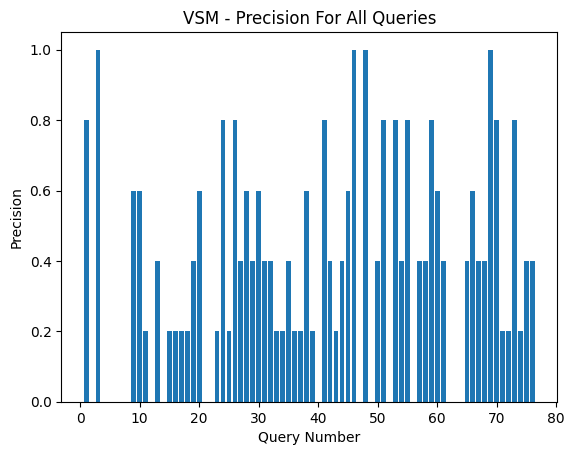

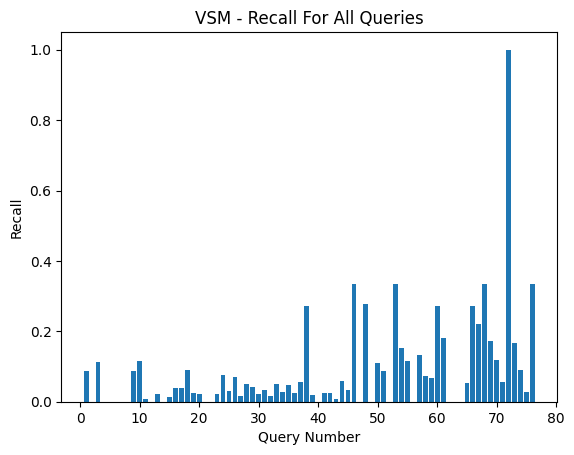

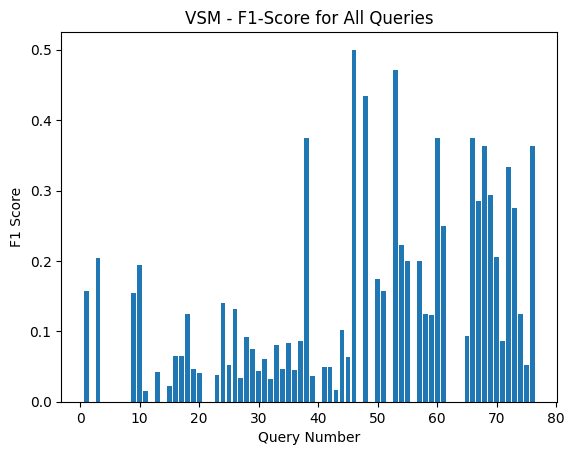

In [858]:
import matplotlib.pyplot as plt

plt.bar(vsm_query_num_precision, vsm_precisions)
plt.xlabel("Query Number")
plt.ylabel("Precision")
plt.title("VSM - Precision For All Queries")
plt.show()

plt.bar(vsm_query_num_recall, vsm_recalls)
plt.xlabel("Query Number")
plt.ylabel("Recall")
plt.title("VSM - Recall For All Queries")
plt.show()

plt.bar(vsm_query_num_f1, vsm_f1_scores)
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.title("VSM - F1-Score for All Queries")
plt.show()


In [859]:
# Printing the Average scores for the VSM model

print('The Mean Average Precision for the VSM model is: ',(sum(vsm_precisions)/len(vsm_precisions))*100,'%')
print('The Mean Average Recall for the VSM model is: ',(sum(vsm_recalls)/len(vsm_recalls))*100,'%')
print('The Mean Average F1-Score for the VSM model is: ',(sum(vsm_f1_scores)/len(vsm_f1_scores))*100,'%')

The Mean Average Precision for the VSM model is:  37.105263157894726 %
The Mean Average Recall for the VSM model is:  8.78203547372032 %
The Mean Average F1-Score for the VSM model is:  11.774070001142452 %


In [860]:
for i, retrieved_doc in enumerate(rel_retrieved_documents):
    # retrieves relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set) # calculates precision

    # prints out individual precision values for each query based on the VS model
    #print(f"Query: {relevant_doc['query_id']} Precision: {precision}")


**BM25 Evaluation**

In [861]:
# Define a function to calculate precision
def calculate_precision(relevant_docs, retrieved_docs):
    # Convert the lists to sets for faster calculations
    relevant_docs_set = set(relevant_docs)
    retrieved_docs_set = set(retrieved_docs)

    # Calculate the intersection of relevant_docs_set and retrieved_docs_set
    intersection = relevant_docs_set.intersection(retrieved_docs_set)

    # Calculate precision
    precision = len(intersection) / len(retrieved_docs)

    return precision

# Define a function to calculate recall
def calculate_recall(relevant_docs, retrieved_docs):
    # Convert the lists to sets for faster calculations
    relevant_docs_set = set(relevant_docs)
    retrieved_docs_set = set(retrieved_docs)

    # Calculate the intersection of relevant_docs_set and retrieved_docs_set
    intersection = relevant_docs_set.intersection(retrieved_docs_set)

    # Calculate recall
    recall = len(intersection) / len(relevant_docs)

    return recall

# Define a function to calculate F1 score
def calculate_f1_score(precision, recall):
    if precision == 0 or recall == 0:
        return 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score

# Calculate F1 score for each of the first 5 queries
BM25query_nums_f1_score = []
BM25f1_scores = []

for i, BM25_relevant_doc in enumerate(BM25_relevant_docs):

    try:
        # Get the corresponding relevant documents for the query
        retrieved_doc = next(rd for rd in rel_retrieved_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == BM25_relevant_doc['query_id'])

        # Calculate precision and recall
        BM25retrieved_docs = BM25_relevant_doc['retrieved_document_ids']
        BM25relevant_docs = relevant_doc['relevant_document_ids']
        BM25precision = calculate_precision(BM25relevant_docs, BM25retrieved_docs)
        BM25recall = calculate_recall(BM25relevant_docs, BM25retrieved_docs)

        # Calculate F1 score
        BM25f1_score = calculate_f1_score(BM25precision, BM25recall)

        # Append query number and F1 score to lists
        BM25query_nums_f1_score.append(i+1)
        BM25f1_scores.append(BM25f1_score)
    except StopIteration:
        pass


**Visualisation of BM25**

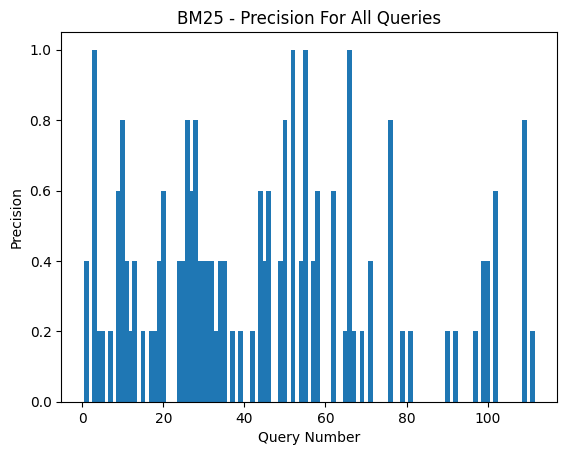

The BM25 Mean Average Precision across all Queries is: 33.157894736842096 %


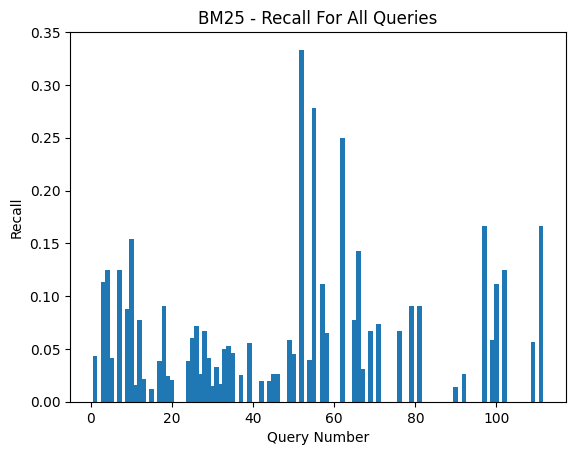

The BM25 Average Recall across all Queries is: 5.5646061951658385 %


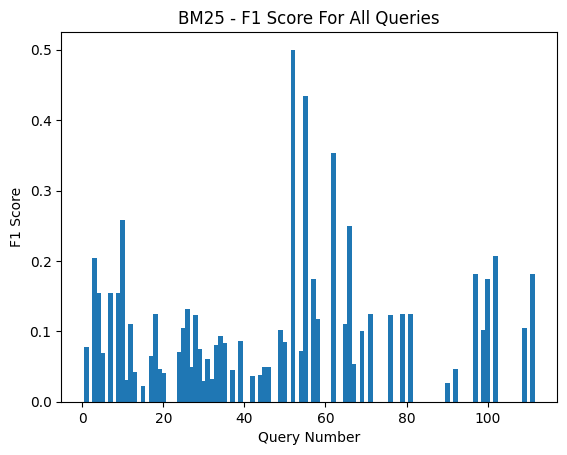

The BM25 Average F1-Score across all Queries is: 8.773443043552364 %


In [862]:
# Create bar chart
bar_width = 1.2
plt.bar(BM25query_nums_precision, BM25precisions, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("Precision")
plt.title("BM25 - Precision For All Queries")
plt.show()

print('The BM25 Mean Average Precision across all Queries is:',(sum(BM25precisions)/len(BM25precisions)*100),'%')

# Create bar chart for recall
bar_width = 1.2
plt.bar(BM25query_nums_recall, BM25recalls, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("Recall")
plt.title("BM25 - Recall For All Queries")
plt.show()

print('The BM25 Average Recall across all Queries is:',(sum(BM25recalls)/len(BM25recalls)*100),'%')

# Create bar chart for F1 score
bar_width = 1.2
plt.bar(BM25query_nums_f1_score, BM25f1_scores, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.title("BM25 - F1 Score For All Queries")
plt.show()

print('The BM25 Average F1-Score across all Queries is:',(sum(BM25f1_scores)/len(BM25f1_scores)*100),'%')

In [863]:
# Printing the Average scores for the BM25 model

print('The BM25 Mean Average Precision across all Queries is:',(sum(BM25precisions)/len(BM25precisions)*100),'%')
print('The BM25 Average Recall across all Queries is:',(sum(BM25recalls)/len(BM25recalls)*100),'%')
print('The BM25 Average F1-Score across all Queries is:',(sum(BM25f1_scores)/len(BM25f1_scores)*100),'%')

The BM25 Mean Average Precision across all Queries is: 33.157894736842096 %
The BM25 Average Recall across all Queries is: 5.5646061951658385 %
The BM25 Average F1-Score across all Queries is: 8.773443043552364 %


# **Comparative Analysis**

Below we have a visualisation comparing the Mean Average Precision (MAP) scores for both models we have created. MAP takes the precision of each individual query, sums it and divides against the total number of queries. It acts as a robust comparative tool that can assist us in determining which of our models performs best against our project aim.

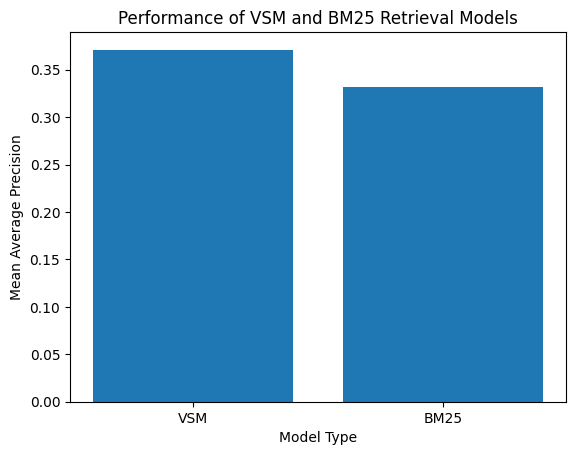

In [864]:
# Plotting the MAP performance of VSM and BM25 models

VSM_map = sum(vsm_precisions) / len(vsm_precisions)
BM25_map = sum(BM25precisions)/len(BM25precisions)

plt.bar(['VSM', 'BM25'], [VSM_map, BM25_map])

# Set the axis labels and title
plt.xlabel('Model Type')
plt.ylabel('Mean Average Precision')
plt.title('Performance of VSM and BM25 Retrieval Models')

# Display the plot
plt.show()

Graphs comparing the Average Recall and the F1-scores of our models have been produced, although MAP will be the main focus of our performance metric evaluation

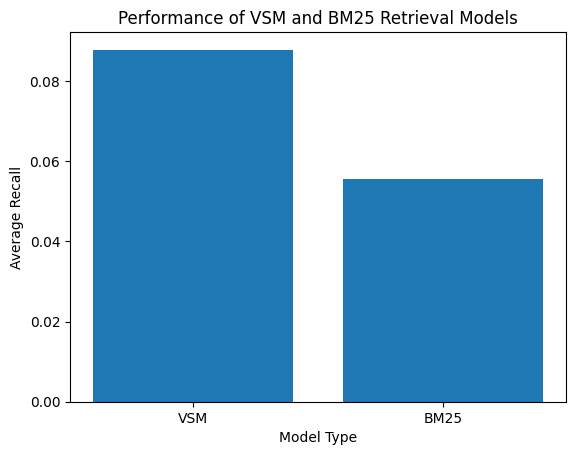

In [865]:
# Plotting the Average Recall performance of VSM and BM25 models

VSM_recall = sum(vsm_recalls)/len(vsm_recalls)
BM25_recall = sum(BM25recalls)/len(BM25recalls)

plt.bar(['VSM', 'BM25'], [VSM_recall, BM25_recall])

# Set the axis labels and title
plt.xlabel('Model Type')
plt.ylabel('Average Recall')
plt.title('Performance of VSM and BM25 Retrieval Models')

# Display the plot
plt.show()

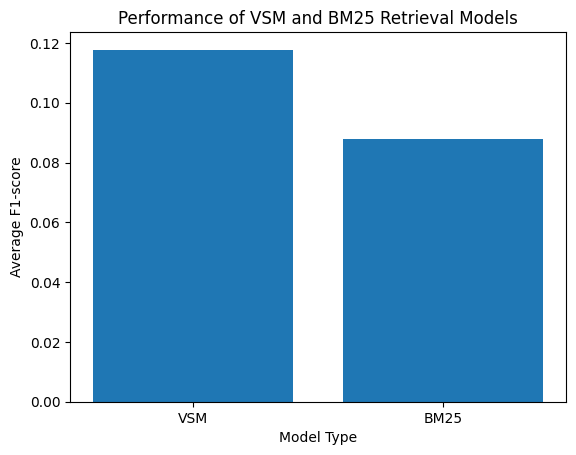

In [866]:
# Plotting the Average Recall performance of VSM and BM25 models

VSM_f1 = sum(vsm_f1_scores)/len(vsm_f1_scores)
BM25_f1 = sum(BM25f1_scores)/len(BM25f1_scores)

plt.bar(['VSM', 'BM25'], [VSM_f1, BM25_f1])

# Set the axis labels and title
plt.xlabel('Model Type')
plt.ylabel('Average F1-score')
plt.title('Performance of VSM and BM25 Retrieval Models')

# Display the plot
plt.show()

### Calculating the Execution time of Both models

In [867]:
print('The exectution time of the VSM model is: ', VSMelapsed_time ,'Seconds')
print('The exectution time of the BM25score computation from the documents is: ', BM25elapsed_time ,'Seconds')
print('The exectution time of BM25 document ranking is:',BM25resultselapsed_time,'Seconds' )
print('The total exectution time of the BM25 model is:',BM25elapsed_time+BM25resultselapsed_time,'Seconds' )

The exectution time of the VSM model is:  1.1944677829742432 Seconds
The exectution time of the BM25score computation from the documents is:  0.9318044185638428 Seconds
The exectution time of BM25 document ranking is: 2.029481887817383 Seconds
The total exectution time of the BM25 model is: 2.9612863063812256 Seconds


## **Concluding statements**


To conclude we can see that the VSM model performs better than the BM25 model based on our analysis of all performance metrics. The VSM model is able to achive higher scores on all metrics such as MAP, average Recall and F1-Score.

The VSM model has an MAP value of 37.11%, average recall of 8.78% and an average F1-score of 11.77%.

The BM25 model has an MAP value of 33.16%, average recall of 8.56% and an average F1-score of 8.77%.

Furthermore, on our specific dataset the VSM model is able to return the top 5 results faster than the BM25 model. It takes around 1.03 seconds for the VSM model and around 2.8 seconds for the BM25 model to return retrieved documents. 

Its worth noting that the total execution time for the BM25 model from start to finish is 3.69 seconds but since the BM25 scores can be calculated in advance before queries are interpretted we focus only on how long the model/system requires to return relevant documents instead.


# **Optimisation Steps performed/attempted**

1.   Iterative process used to manually fine tune the BM25 model parameters to increase MAP and other performance metrics.
2.   Attempted to use Elastic search for Indexing but manual indexing was used due to problems encountered with elastic search.
3.Preprocessing optimisations: Preprocessing steps such as stopword removal & lemmatization we used to improve the efficiency and effectiveness. The aim was to use the  apropriate preprocessing techniques to reduce the size of the index, reduce the processing overhead, and improve the recall and precision of results.

# Demonstrating/Testing both models on Custom Queries

In [868]:
# VSM model for demosntration on custom queries

def VSM2(corpus, num_results):
    # creates document-term frequency matrix and generates TF-IDF matrix
    vectorizer = CountVectorizer()
    term_matrix = vectorizer.fit_transform(corpus)
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(term_matrix)

    # allows custom query from the user
    while True:
        query = input("Enter your query here (type 'x' to exit): ")
        if query == 'x':
            break

        # create query vector and calculate cosine similarity for individual documents
        query_matrix = vectorizer.transform([query])
        query_tfidf = tfidf_transformer.transform(query_matrix)
        cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
        top_results = cosine_similarities.argsort()[::-1][:num_results]

        # prints out the top-n matching documents for the query
        # prints out the top-n matching documents for each query
        print(f"Top {num_results} matching documents for query {query_id+1}: '{query}'")
        for i, index in enumerate(top_results):
            print(f"Rank {i+1}: {documents[index]}")
        print()

In [872]:
VSM2(corpus,5)

Enter your query here (type 'x' to exit): linear regression analysis
Top 5 matching documents for query 113: 'linear regression analysis'
Rank 1: {'document_id': '833', 'title': 'A New Linear Notation System Based on Combinations of Carbon and Hydrogen', 'authors': 'Skolnic, Herman', 'abstract': 'A new linear notation system is described which was designed to have a one-to-one correspondence with the chemical structures represented by the notations.. Each notation is unique and unambiguous, yet simple and compatible with computer input and output characters.. The symbols used in the notation system denote carbon in terms of bounds and attached hydrogen(s).. The notation system is illustrated with acyclic, carbocyclic, and heterocyclic examples..', 'source': '', 'year': ''}
Rank 2: {'document_id': '1092', 'title': 'Method for Relating the Structure and  Properties of Chemical Compounds', 'authors': 'Adamson, G.W.', 'abstract': 'The structure diagrams of chemical compounds are widely use

In [870]:
# VSM model for demosntration on custom queries
class BM25Retrieval:
    def __init__(self, bm25_scores):
        self.bm25_scores = bm25_scores
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_query(self, query_text):
        # Tokenize and convert to lowercase
        tokens = word_tokenize(query_text.lower())
        # Remove special characters, numbers, and punctuation marks
        filtered_query = [word for word in tokens if word not in string.punctuation + string.digits]
        # Remove quotation marks
        filtered_query = [word.replace("'", "").replace('"', '') for word in filtered_query]
        # Remove stop words
        filtered_query = [word for word in filtered_query if word not in self.stop_words]
        # Perform lemmatization
        lemmatized_query = [self.lemmatizer.lemmatize(word) for word in filtered_query]
        # Join tokens back to form a string
        preprocessed_query = ' '.join(lemmatized_query)
        return preprocessed_query

    def retrieve_ranking(self, query):
        q_terms = query.split(' ')
        common_terms = list(set(q_terms) & set(self.bm25_scores.columns))
        q_terms_only = self.bm25_scores[common_terms]
        score_q_d = q_terms_only.sum(axis=1)
        return sorted(zip(self.bm25_scores.index.values, score_q_d.values),
                      key=lambda tup: tup[1],
                      reverse=True)

    def run_bm25_on_query(self, query_text):
        preprocessed_query = self.preprocess_query(query_text)
        ranking = self.retrieve_ranking(preprocessed_query)
        top_5_documents = ranking[:5]
        top_5_document_ids = [doc_id for doc_id, _ in top_5_documents]

        print("Top 5 Relevant Documents:")
        for doc_id in top_5_document_ids:
            document_info = documents[doc_id]
            print("DocumentID:", doc_id+1)
            print("Document Title:", document_info["title"])
            print("Document Author:", document_info["authors"])
            print("Document Source:", document_info["source"])
            print("Document Year:", document_info["year"])
            print("Document Content:", document_info["abstract"])
            print("------------------------------")

        return top_5_document_ids

In [873]:
# Instance of BM25Retrieval
bm25_retrieval = BM25Retrieval(bm25_scores)

# Getting user input for query
query_text = input("Enter your query: ")

# Run BM25 on the query and get the top 5 relevant document IDs
top_5_document_ids = bm25_retrieval.run_bm25_on_query(query_text)

Enter your query: linear regression analysis
Top 5 Relevant Documents:
DocumentID: 1092
Document Title: Method for Relating the Structure and  Properties of Chemical Compounds
Document Author: Adamson, G.W.
Document Source: 
Document Year: 
Document Content: The structure diagrams of chemical compounds are widely used in the communication of chemistry. They are also used in chemical information systems, mainly as keys for the retrieval of associated information. However some chemical information systems hold property data as well as structure diagrams in machine-readable forms. If structure-property relationships could be investigated easily within chemical information systems, then the usefulness of the systems would be considerably increased. Described below are some results which have been obtained during investigation of structure- property relationships using a combination of regression analysis and some techniques of chemical structure handling used in information systems.
------